## Clase 4 nov. actividades
- hub de mayor tamaño
- identificar las comunidades, plotearlas de diferente color

### 6/nov
1. crear mapa de calor utilizando el umbral para mostrar matriz binaria
2. ambos gráficos (grafo 3d y mapa de calor) juntos

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.signal import coherence, hilbert
import scipy.io

In [6]:
import mne
raw = mne.io.read_raw_edf(r"/Users/Maca/Desktop/Todo todo/UNAM/5º Semestre/Neurociencias-2026-1/S03_datasets/EEG_practica/chb01_01.edf", preload=True)
sfreq_target = 256            
fmin, fmax = 8, 13  # correspondiente a la banda de interés, en este caso es alpha. 

raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data_eeg = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

coordenadas = r"/Users/Maca/Desktop/Todo todo/UNAM/5º Semestre/Neurociencias-2026-1/S03_datasets/EEG_practica/coordenadas_bipolares_eeg.csv"
coordenadas_df = pd.read_csv(coordenadas)
coordenadas_df.set_index("canal", inplace = True, drop = True)
#pos3D = {canal : (coordenadas_df.loc[canal, "x"],
                # coordenadas_df.loc[canal, "y"],
                # coordenadas_df.loc[canal, "z"]) for canal in coordenadas_df.index}

Extracting EDF parameters from /Users/Maca/Desktop/Todo todo/UNAM/5º Semestre/Neurociencias-2026-1/S03_datasets/EEG_practica/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


/var/folders/48/5mv2c8bn0mn_vl9c6chb0flm0000gp/T/ipykernel_1467/1621597972.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(r"/Users/Maca/Desktop/Todo todo/UNAM/5º Semestre/Neurociencias-2026-1/S03_datasets/EEG_practica/chb01_01.edf", preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [7]:
# MATRIZ DE COHERENCIA ESPECTRAL 
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data_eeg[i], data_eeg[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

eeg_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
np.fill_diagonal(eeg_df.values, 0)

In [9]:
data = eeg_df.stack().values
threshold = np.percentile(data, 25)
threshold
data = eeg_df[eeg_df>threshold].stack().values
df_filtered = eeg_df.where(eeg_df > threshold, 0)

eeg_graph = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())

# COMUNIDADES
from networkx.algorithms import community
communities = community.greedy_modularity_communities(eeg_graph)

# HUBS
degree_dict = dict(eeg_graph.degree())
betweenness = nx.betweenness_centrality(eeg_graph)
betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

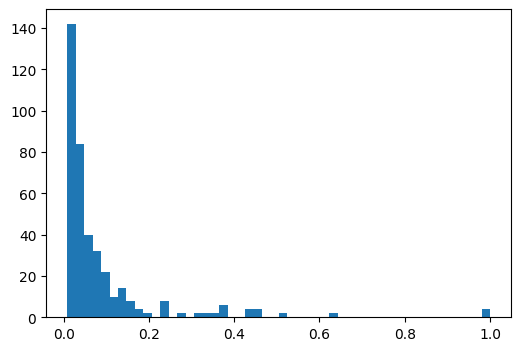

In [10]:
hub = betweenness[0]

plt.figure(figsize=(6, 4))

plt.hist(data, bins=50)
plt.show()

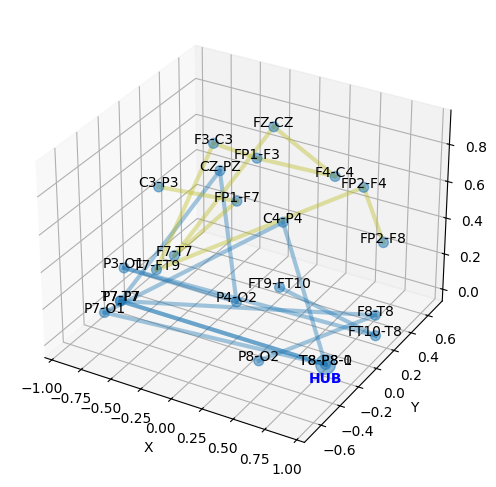

In [15]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Creamos el plot3D del grafo
x, y, z = coordenadas_df.loc[:, 'x'].values, coordenadas_df.loc[:, 'y'].values, coordenadas_df.loc[:, 'z'].values
colors = [
    'tab:blue',      # cyan
    'tab:olive',    # verde oliva
    'tab:green',     # verde
    'tab:red',       # rojo
    'tab:purple',    # morado
    'tab:brown',     # café
    'tab:pink',      # rosa
    'tab:gray',      # gris
    'tab:orange',     # naranja
    'tab:cyan',      # azul
    'gold',          # dorado
    'deepskyblue',   # azul brillante
    'limegreen',     # verde limón
    'magenta',       # magenta
    'black'          # negro
]
nodo_size = [50 if idx != hub[0] else 200 for idx in coordenadas_df.index]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# DIBUJAR LOS NODOS
sc = ax.scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
    ax.text(x_, y_, z_, coordenadas_df.index[idx], fontsize=10, ha='center')
    if coordenadas_df.index[idx] == hub[0]:
        ax.text(x_, y_, z_-0.1, 'HUB', color='blue', fontweight='bold', fontsize=10, ha='center')

# Dibujar aristas (basado en comunidades)
for n_communitie, communitie in enumerate(communities):
    for idx in range(len(communitie)-1):
        nodo1, nodo2 = list(communitie)[idx], list(communitie)[idx+1]
        x_ = [coordenadas_df.loc[nodo1, 'x'], coordenadas_df.loc[nodo2, 'x']]
        y_ = [coordenadas_df.loc[nodo1, 'y'], coordenadas_df.loc[nodo2, 'y']]
        z_ = [coordenadas_df.loc[nodo1, 'z'], coordenadas_df.loc[nodo2, 'z']]
        ax.plot(x_, y_, z_, color=colors[n_communitie], alpha=0.4, linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


### Actividad 6/11
1. crear mapa de calor utilizando el umbral para mostrar matriz binaria
2. ambos gráficos (grafo 3d y mapa de calor) juntos

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sc = ax.scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
    ax.text(x_, y_, z_, coordenadas_df.index[idx], fontsize=10, ha='center')
    if coordenadas_df.index[idx] == hub[0]:
        ax.text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')

# Dibujar aristas (basado en comunidades)
for n_communitie, communitie in enumerate(communities):
    for idx in range(len(communitie)-1):
        nodo1, nodo2 = list(communitie)[idx], list(communitie)[idx+1]
        x_ = [coordenadas_df.loc[nodo1, 'x'], coordenadas_df.loc[nodo2, 'x']]
        y_ = [coordenadas_df.loc[nodo1, 'y'], coordenadas_df.loc[nodo2, 'y']]
        z_ = [coordenadas_df.loc[nodo1, 'z'], coordenadas_df.loc[nodo2, 'z']]
        ax.plot(x_, y_, z_, color=colors[n_communitie], alpha=0.4, linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
axes[1]sns.heatmap(df_filtered.values, 
                 annot = False, cmap = "GnBu", fmt = ".2f",
                 xticklabels = df_filtered.columns, yticklabels = df_filtered.columns)


axes[0].set_title("Grafo3D")
axes[1].set_title("Heatmap")
plt.show()

SyntaxError: invalid syntax (2505048717.py, line 21)